# Registration of video frames using optimal transport (MP space)

## Description

### Problem and general approach

The practical problem we are ultimately trying to solve here is learning to 'straighten' videos of freely-behaving *C. elegans* specimens -- more precisely, to map the different frames of a given video into a canonical space where the spatial footprints of the worm's neurons remain static across frames. One way to accomplish this is to learn a spatial transformation between each pair of successive frames that captures the worm's motion, and compose these transformations in order to map all frames to a shared space.

Image registration -- the problem of learning the spatial transformation between two images -- has been studied extensively in the computer vision literature. In its most general case, it can be stated as follows. Given two images $A$ and $B$ that are related by a spatial transform $T$ with a known parameteric form and set of parameters $\theta$, we want to estimate $\theta$. Without any other assumptions, this case of the problem is extremely difficult to solve. However, for our purposes working with microscopy images, there are a number of additional assumptions we can make. One is that all of the images we work with consist of small regions of high pixel intensity on top of a black background. This means we can expect all regions of high pixel intensity to be affected by $T$. Another is that, because $A$ and $B$ are successive frames in a microscopy video with a reasonably high sample rate, the displacement of objects between $A$ and $B$ should be small, and the correspondence between objects in $A$ and $B$ should be unambiguous.

Given these assumptions, we believe we can use an optimal transport (OT) plan to approximate the motion of the objects between images $A$ and $B$. By assuming a parametric form for the transport plan we expect to result from a particular transform $T$ (in terms of its parameters $\theta$), we can find the value of $\theta$ that minimizes the difference between this transport plan and the true optimal transport plan. 

### Derivation

#### Notation

- $A, B$: Images related by $T_{\theta}$
- $T_{\theta}$: Spatial transform with list of parameters $\theta$, that maps $A$ to $B$
- $n$: Number of pixels in images $A$ and $B$
- $d$: Dimensionality of images $A$ and $B$
- $X$ ($n \times d$): Set of pixel locations in $d$-dimensional space, where $X_i$ be the $i^{th}$ pixel location
- $a$, $b$ ($n \times 1$): Pixel intensities for the images $A$ and $B$ (e.g. $a_i$ is the intensity at location $X_i$ in image $A$)
- $P$ ($n \times n$): Optimal transport matrix for $a$ and $b$
- $\hat{P}_{ij}(\theta)$ ($n \times n$): Parametric form of transportation plan corresponding to $T_{\theta}$

#### Parametric form for transportation plan 

We assume the following parametric form for the transportation plan corresponding to $T_{\theta}$:

$
\begin{equation*}
\hat{P}_{ij}(\theta) = a_i \cdot \exp \big( \frac{-||T_{\theta}(X_i) - X_j||_2^2}{2\sigma^2} \big)
\end{equation*}
$

This form assumes that the transportation plan for a particular $T_{\theta}$ should transport all the mass $a_i$ from a particular pixel in $A$ to a Gaussian point spread function centered at $T_{\theta}(X_i)$, with a spread parameter $\sigma$. It's important to note that, for all values of $\theta$, $\hat{P}(\theta)$ represents a valid joint probability distribution over $(i, j)$, and its first marginal distribution is $a$.

#### Loss function

To estimate $\theta$, we first compute the optimal transportation plan $P$ between the distributions $a$ and $b$, using a cost matrix consisting of squared euclidean distances between the pixel locations in $X$. Then, we minimize the KL divergence between $P$ and $\hat{P}(\theta)$:

$
\begin{equation*}
\theta^* = \underset{\theta}{\mathrm{argmin\ }} D_{KL}(P || \hat{P}(\theta))
\end{equation*}
$

This KL divergence can be computed using the parametric form we chose for $\hat{P}(\theta)$:

$
\begin{align*}
D_{KL}(P || \hat{P}(\theta)) 
    &= \sum_{i, j} P_{ij} \log \frac{P_{ij}}{\hat{P}_{ij}(\theta)} \\
    &= \sum_{i, j} P_{ij} \log P_{ij} - \sum_{i, j} P_{ij} \log \hat{P}_{ij}(\theta) \\
    &= \sum_{i, j} P_{ij} \log P_{ij} - \sum_{i, j} P_{ij} \log \big[ a_i \cdot \exp \big( \frac{-||T_{\theta}(X_i) - X_j||_2^2}{2\sigma^2} \big) \big] \\
    &= \sum_{i, j} P_{ij} \log P_{ij} - \sum_{i, j} P_{ij} \log a_i  + \sum_{i, j} P_{ij} \frac{||T_{\theta}(X_i) - X_j||_2^2}{2\sigma^2} \\
\end{align*} 
$

Minimizing this with respect to $\theta$, we can ignore the first two terms:

$
\begin{align*}
\theta^*
    &= \underset{\theta}{\mathrm{argmin\ }} D_{KL}(P || \hat{P}(\theta)) \\
    &= \underset{\theta}{\mathrm{argmin\ }} \sum_{i, j} P_{ij} \log P_{ij} - \sum_{i, j} P_{ij} \log a_i  + \sum_{i, j} P_{ij} \frac{||T_{\theta}(X_i) - X_j||_2^2}{2\sigma^2} \\
    &= \underset{\theta}{\mathrm{argmin\ }} \sum_{i, j} P_{ij} \frac{||T_{\theta}(X_i) - X_j||_2^2}{2\sigma^2} \\
    &= \underset{\theta}{\mathrm{argmin\ }} \sum_{i, j} P_{ij} \cdot ||T_{\theta}(X_i) - X_j||_2^2 \\
\end{align*}
$

This minimization problem is equivalent to performing a weighted, least-squares regression where the data set consists of all pairs of pixel locations $(X_i, X_j)$, each weighted by their corresponding value $P_{ij}$ in the optimal transport plan.

### Parametric form for $T$ and loss function

In the examples below, we will make $T$ an affine transform, where $T_{\theta}(x) = \alpha + \beta x$, with $\theta = \{\alpha, \beta\}$. The loss function then becomes:

$
\begin{equation*}
\alpha^*, \beta^* = \underset{\alpha, \beta}{\mathrm{argmin\ }} \sum_{i, j} P_{ij} \cdot ||\beta X_i + \alpha - X_j||_2^2
\end{equation*}
$

As noted above, this is equivalent to a weighted, least-squares regression problem, in this case a linear regression, with a dataset containing all pairs of pixel locations. For high-resolution images, this set of points might be prohibitively large, but we can take advantange of the sparsity of $P$ to approximate this sum by only summing over pixel pairs $(i,j)$ where the weight $P_{ij}$ is greater than some chosen threshold.

## Imports and magic

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ot
import h5py
from scipy.ndimage import affine_transform
from scipy.stats import multivariate_normal
from sklearn.linear_model import LinearRegression
from skimage.transform import downscale_local_mean

from otimage import imagerep
from otimage.utils import plot_maxproj, pixel_dist_3d

## Example 1: Recovering known affine mapping applied to synthetic image

In the code below, we create two images related by an affine transformation, and try to use our OT-registration method to recover this transformation and reconstruct image $B$ from image $A$.

### Parameters

In [3]:
# Random seed 
np.random.seed(1993)

# Image size
img_shape = (50, 25, 5)

### Create synthetic data

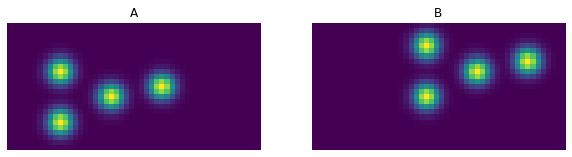

In [4]:
# Ground-truth transformation
beta = np.eye(3, 3)
alpha = np.array([12, 5, 0])

# Covariance used for all components
cov = 3 * np.eye(3)

# Locations of components in image A
x_a = np.array([
    [20, 10, 2],
    [10, 15, 3],
    [10, 5, 4],
    [30, 12, 3],
])

# Locations of components in image B
x_b = (x_a @ beta + alpha).astype(int)

# Array containing both locations
x = np.concatenate((x_a, x_b), axis=0)

# Weights for A and B
a = np.array([1, 1, 1, 1, 0, 0, 0, 0])
b = np.array([0, 0, 0, 0, 1, 1, 1, 1])

# Reconstruct A and B as images
a_img = imagerep.reconstruct_image(x, [cov], a, img_shape)
b_img = imagerep.reconstruct_image(x, [cov], b, img_shape)

plt.figure(figsize=(10, 10))

plt.subplot(121)
plot_maxproj(a_img)
plt.axis('off')
plt.title('A')

plt.subplot(122)
plot_maxproj(b_img)
plt.axis('off')
plt.title('B');

### Compute optimal transport plan between frames

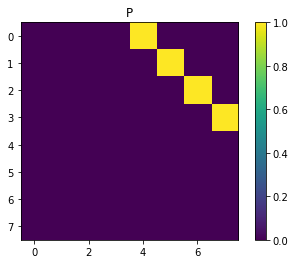

In [5]:
# Normalized distance matrix 
M_nn = ot.dist(x, metric='sqeuclidean')
M = M_nn / np.median(M_nn)

# Compute transport plan
P = ot.emd(a, b, M)

plt.imshow(P)
plt.colorbar()
plt.title('P');

### Minimize cost function to estimate $\alpha$ and $\beta$

In [6]:
# Get pairs of points with values above threshold, and corresponding weights from P matrix
a_idx, b_idx = np.nonzero(P)
pts_a = x[a_idx]
pts_b = x[b_idx]
weights = P[a_idx, b_idx]

# Use sklearn.linear_model.LinearRegression to minimize cost function
model = LinearRegression(fit_intercept=True)
model.fit(pts_a, pts_b, sample_weight=weights)

# Estimates of transform parameters
alpha_est = model.intercept_
beta_est = model.coef_

print('alpha (est):')
print(alpha_est)
print('alpha (true):')
print(alpha)

print('beta (est):')
print(beta_est)
print('beta (true):')
print(beta)

alpha (est):
[1.20000000e+01 5.00000000e+00 2.66453526e-15]
alpha (true):
[12  5  0]
beta (est):
[[ 1.00000000e+00  2.50196237e-16  2.21182797e-15]
 [ 1.33897935e-17  1.00000000e+00 -1.55251030e-16]
 [-6.69489674e-18 -1.49295518e-16  1.00000000e+00]]
beta (true):
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


### Use estimated transform $T_{\alpha^*, \beta^*}$ to reconstruct $B$ from $A$

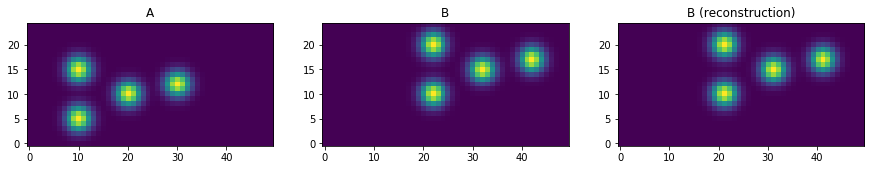

In [7]:
# Reconstruct B from A
x_b_recon = (x_a @ beta_est + alpha_est).astype(int)
b_recon_img = imagerep.reconstruct_image(x_b_recon, [cov], [1/3]*4, img_shape)

plt.figure(figsize=(15, 15))

plt.subplot(131)
plot_maxproj(a_img)
plt.title('A')
        
plt.subplot(132)
plot_maxproj(b_img)
plt.title('B')
        
plt.subplot(133)
plot_maxproj(b_recon_img)
plt.title('B (reconstruction)');

## Example 2: Recovering known affine mapping applied to real image

### Load frames and MP components from file

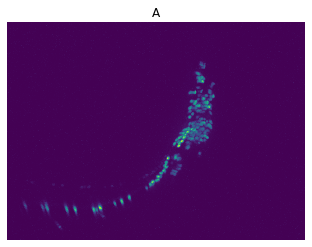

In [8]:
data_path = '/home/mn2822/Desktop/WormOT/data/zimmer/sample/frame_mp_0000_0002.h5'
n_iter = 50

with h5py.File(data_path) as f:
    
    # Load global MP parameters
    max_iter = f['n_iter'][...]
    cov = f['cov'][...]
    
    # Load frame and MPs
    a_full_img = f['frame_1/img'][...]
    x_a = f['frame_1/pts'][0:n_iter, :]
    wts_a = f['frame_1/wts'][0:n_iter].flatten()
    
img_shape = a_full_img.shape
  
plot_maxproj(a_full_img)
plt.title('A')
plt.axis('off');

### Reconstruct images in MP coordinate system

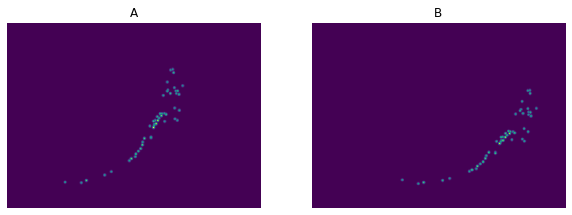

In [9]:
# Ground-truth transformation (rotation + translation)
theta = np.pi / 16
beta = np.array([
    [np.cos(theta), -np.sin(theta), 0], 
    [np.sin(theta),  np.cos(theta), 0],
    [0,              0,             1]
])
alpha = np.array([100, 50, 0])

# Create MPs for B by applying transformation to A (weights are same)
x_b = (x_a @ beta + alpha).astype(int)
wts_b = wts_a

# Matrix containing locations of both sets of MPs
x = np.concatenate((x_a, x_b), axis=0)

# Put weights in common coordinate system and normalize them
a_nn = np.concatenate((wts_a, np.zeros(n_iter)), axis=0)
b_nn = np.concatenate((np.zeros(n_iter), wts_b), axis=0)
a = a_nn / np.sum(a_nn)
b = b_nn / np.sum(b_nn)

# Reconstruct A and B as images
a_img = imagerep.reconstruct_image(x, [cov], a, img_shape)
b_img = imagerep.reconstruct_image(x, [cov], b, img_shape)

plt.figure(figsize=(10, 10))

plt.subplot(121)
plot_maxproj(a_img)
plt.axis('off')
plt.title('A')

plt.subplot(122)
plot_maxproj(b_img)
plt.axis('off')
plt.title('B');

### Compute optimal transport plan between frames

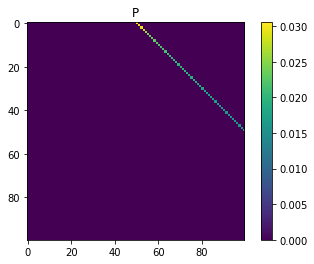

In [10]:
# Normalized distance matrix 
M_nn = ot.dist(x, metric='sqeuclidean')
M = M_nn / np.median(M_nn)

# Compute transport plan
P = ot.emd(a, b, M)

plt.imshow(P)
plt.colorbar()
plt.title('P');

### Minimize cost function to estimate $\alpha$ and $\beta$

In [11]:
# Get pairs of points with values above threshold, and corresponding weights from P matrix
a_idx, b_idx = np.nonzero(P)
pts_a = x[a_idx]
pts_b = x[b_idx]
weights = P[a_idx, b_idx]

# Use sklearn.linear_model.LinearRegression to minimize cost function
model = LinearRegression(fit_intercept=True)
model.fit(pts_a, pts_b, sample_weight=weights)

# Estimates of transform parameters
alpha_est = model.intercept_
beta_est = model.coef_

print('alpha (est):')
print(alpha_est)
print('beta (est):')
print(beta_est)

alpha (est):
[9.99444447e+01 4.97776299e+01 1.77635684e-14]
beta (est):
[[ 9.79395442e-01  1.96399249e-01 -5.24268663e-03]
 [-1.95751053e-01  9.81177267e-01 -7.60176021e-03]
 [-3.47720613e-17  4.37815361e-18  1.00000000e+00]]


### Use estimated transform $T_{\alpha^*, \beta^*}$ to reconstruct $B$ from $A$

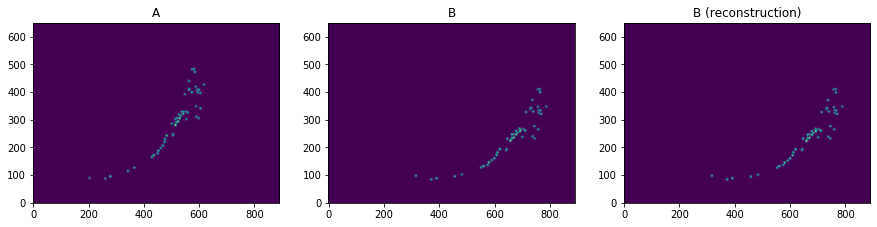

In [12]:
# Points and weights for A
pts = x[0:n_iter]
wts = a[0:n_iter]

x_b_recon = (pts @ beta_est.T + alpha_est).astype(int)

# Only plot points that fall inside image
plot_idx = np.all((x_b_recon >= 0) & (x_b_recon < img_shape), axis=1)
x_b_recon_plot = x_b_recon[plot_idx]
wts_plot = wts[plot_idx]

b_recon_img = imagerep.reconstruct_image(x_b_recon_plot, [cov], wts_plot, img_shape)

plt.figure(figsize=(15, 15))

plt.subplot(131)
plot_maxproj(a_img)
plt.title('A')
        
plt.subplot(132)
plot_maxproj(b_img)
plt.title('B')
        
plt.subplot(133)
plot_maxproj(b_recon_img)
plt.title('B (reconstruction)');

## Example 3: Estimating unknown map between two real images

### Load frames and MP components from file

In [13]:
data_path = '/home/mn2822/Desktop/WormOT/data/zimmer/sample/frame_mp_0000_0002.h5'
n_iter = 50

with h5py.File(data_path) as f:
    
    # Load global MP parameters
    max_iter = f['n_iter'][...]
    cov = f['cov'][...]
    
    # Load first frame (and MPs)
    a_full_img = f['frame_1/img'][...]
    x_a = f['frame_1/pts'][0:n_iter, :]
    wts_a = f['frame_1/wts'][0:n_iter].flatten()
    
    # Load second frame (and MPs)
    b_full_img = f['frame_2/img'][...]
    x_b = f['frame_2/pts'][0:n_iter, :]
    wts_b = f['frame_2/wts'][0:n_iter].flatten()
    
img_shape = a_full_img.shape
  
plt.figure(figsize=(10, 10))

plt.subplot(121)
plot_maxproj(a_full_img)
plt.title('A')
plt.axis('off')

plt.subplot(122)
plot_maxproj(b_full_img)
plt.title('B')
plt.axis('off');

KeyError: "Unable to open object (object 'n_iter' doesn't exist)"

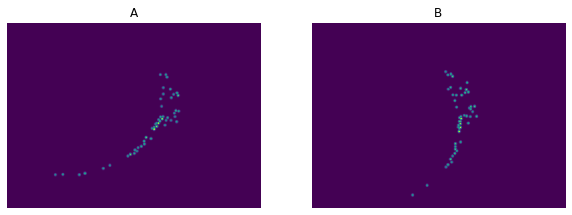

In [14]:
# Matrix containing locations of both sets of MPs
x = np.concatenate((x_a, x_b), axis=0)

# Put weights in common coordinate system and normalize them
a_nn = np.concatenate((wts_a, np.zeros(n_iter)), axis=0)
b_nn = np.concatenate((np.zeros(n_iter), wts_b), axis=0)
a = a_nn / np.sum(a_nn)
b = b_nn / np.sum(b_nn)

# Reconstruct A and B as images
a_img = imagerep.reconstruct_image(x, [cov], a, img_shape)
b_img = imagerep.reconstruct_image(x, [cov], b, img_shape)

plt.figure(figsize=(10, 10))

plt.subplot(121)
plot_maxproj(a_img)
plt.axis('off')
plt.title('A')

plt.subplot(122)
plot_maxproj(b_img)
plt.axis('off')
plt.title('B');

### Compute optimal transport plan between frames

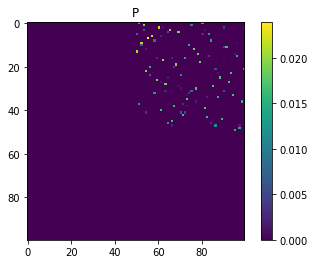

In [15]:
# Normalized distance matrix 
M_nn = ot.dist(x, metric='sqeuclidean')
M = M_nn / np.median(M_nn)

# Compute transport plan
P = ot.emd(a, b, M)

plt.imshow(P)
plt.colorbar()
plt.title('P');

### Minimize cost function to estimate $\alpha$ and $\beta$

In [16]:
# Get pairs of points with values above threshold, and corresponding weights from P matrix
a_idx, b_idx = np.nonzero(P)
pts_a = x[a_idx]
pts_b = x[b_idx]
weights = P[a_idx, b_idx]

# Use sklearn.linear_model.LinearRegression to minimize cost function
model = LinearRegression(fit_intercept=True)
model.fit(pts_a, pts_b, sample_weight=weights)

# Estimates of transform parameters
alpha_est = model.intercept_
beta_est = model.coef_

print('alpha (est):')
print(alpha_est)
print('beta (est):')
print(beta_est)

alpha (est):
[350.70619172 -82.3635308    7.4576774 ]
beta (est):
[[ 5.39659280e-01 -3.42298337e-01 -9.28036336e-01]
 [ 2.44327316e-01  8.77841748e-01  1.63276196e+00]
 [-5.26048794e-03 -2.36781502e-04  5.72745507e-01]]


### Use estimated transform $T_{\alpha^*, \beta^*}$ to reconstruct $B$ from $A$

#### MP space

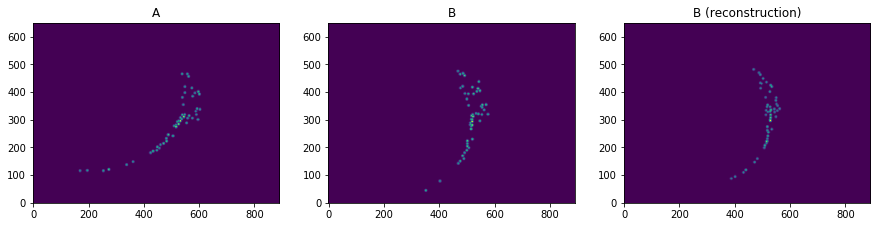

In [17]:
# Points and weights for A
pts = x[0:n_iter]
wts = a[0:n_iter]

x_b_recon = (pts @ beta_est.T + alpha_est).astype(int)

# Only plot points that fall inside image
plot_idx = np.all((x_b_recon >= 0) & (x_b_recon < img_shape), axis=1)
x_b_recon_plot = x_b_recon[plot_idx]
wts_plot = wts[plot_idx]

b_recon_img = imagerep.reconstruct_image(x_b_recon_plot, [cov], wts_plot, img_shape)

plt.figure(figsize=(15, 15))

plt.subplot(131)
plot_maxproj(a_img)
plt.title('A')
        
plt.subplot(132)
plot_maxproj(b_img)
plt.title('B')
        
plt.subplot(133)
plot_maxproj(b_recon_img)
plt.title('B (reconstruction)');

#### Image space

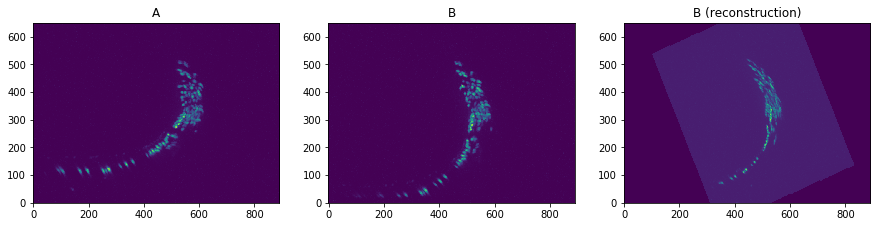

In [18]:
# Reconstruct A from B
inv_beta_est = np.linalg.inv(beta_est)
inv_alpha_est = -inv_beta_est @ alpha_est
b_full_img_recon = affine_transform(a_full_img, inv_beta_est, inv_alpha_est)

plt.figure(figsize=(15, 15))

plt.subplot(131)
plot_maxproj(a_full_img)
plt.title('A')
        
plt.subplot(132)
plot_maxproj(b_full_img)
plt.title('B')
        
plt.subplot(133)
plot_maxproj(b_full_img_recon)
plt.title('B (reconstruction)');